In [1]:
import os
import torch
import scipy.io
import matplotlib.pyplot as plt
import cvxpy as cp
import seaborn as sns
from tqdm import tqdm
import numpy as np

os.chdir('..')
import data_processing.preprocessing as preprocessing
from config import left_cut, right_cut
import utils
from utils import beerlamb_multi

sns.set()

In [ ]:
#img = scipy.io.loadmat('dataset/LWP483_10Jan2017_SharedHyperProbe.mat')
img = scipy.io.loadmat('dataset/2pigs/lwp475/LWP475_Ws_14Nov2016_1.mat')
#img = scipy.io.loadmat('dataset/2pigs/lwp478/LWP474_Ws_07Nov2016.mat')

### Visualising spectrograms with calibration
intensity1_c = []
intensity2_c = []

wavelengths = img['wavelengths'].astype(float)
#white_full = img['refSpectrum'].astype(float)
white_full = img['refIntensity'].astype(float)
#dark_full = img['DarkCount'].astype(float)
dark_full = img['darkcount'].astype(float)
#spectr = img['spectralDatameasured'].astype(float)
spectr = img['spectralDataAll'].astype(float)

idx = (wavelengths >= left_cut) & (wavelengths <= right_cut)
wavelengths = wavelengths[idx]
spectr = spectr[idx.squeeze()]
#dark_full = dark_full[idx.squeeze()]
white_full = white_full[idx.squeeze()]

# We wanna calibrate our HSI images w.r.t. white reference. Why? Because we saw by looking at the raw data that different
# wavelengths have different reflection from the white materila (i.e. reflecting 99% of light). So
# we calibrate our HSI images
print(white_full.shape, dark_full.shape, wavelengths.shape, spectr.shape)

fig, (ax, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))

i = 100
spectr_1 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
ax.plot(wavelengths, spectr_1)
#ax.plot(wavelengths, spectr)
ax.set_xlabel("Wavelength", fontsize=15)
ax.set_title("Base Spectrogram", fontsize=15)
#ax.set_ylim(-0.01, 0.3)

i = 7830  #7830
spectr_2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
ax1.plot(wavelengths, spectr_2)
ax1.set_xlabel("Wavelength", fontsize=15)
#ax1.plot(wavelengths, spectr[:,100])
#ax.set_xlabel("Wavelength", fontsize=20)
ax1.set_title("Hypoxia Spectrogram", fontsize=15)
#ax1.set_ylim(-0.01, 0.3)

spectr_1[spectr_1 <= 0] = 0.0001
spectr_2[spectr_2 <= 0] = 0.0001
spectr_3 = spectr_2 / spectr_1
ax2.plot(wavelengths, spectr_3)
ax2.set_xlabel("Wavelength", fontsize=15)
ax2.set_title("Diff Spectrogram", fontsize=15)

 26%|██▌       | 2045/7830 [01:03<03:00, 32.12it/s]


KeyboardInterrupt: 

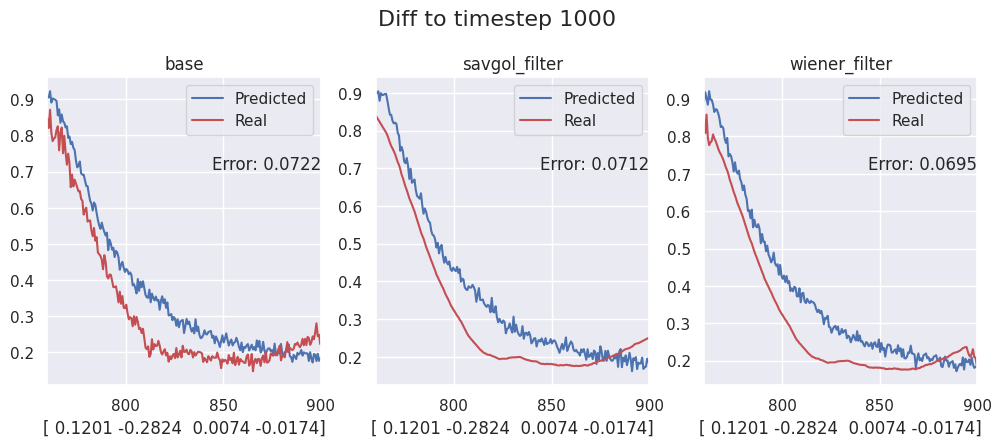

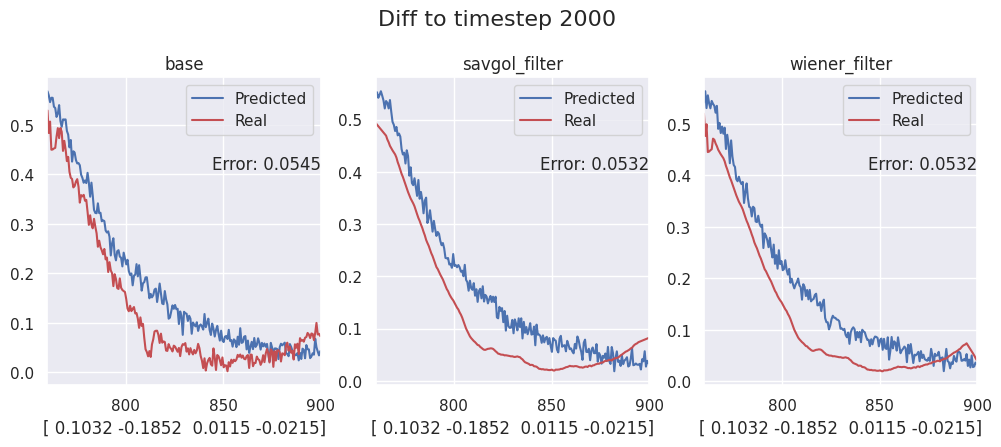

In [5]:
cut = 7830

ref_spectr = (spectr[:, 0] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
ref_spectr[ref_spectr <= 0] = 0.0001

spectra_list = []
coef_list = []
for i in tqdm(range(1, cut+1)):
    #if i not in [100,200,400,2000]: continue
    spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
    spectr2[spectr2 <= 0] = 0.0001

    coef_diff, spect_diff = optimisation(ref_spectr, spectr2, i)

    spectra_list.append(spect_diff)
    coef_list.append(coef_diff)

In [ ]:
utils.save_data(ref_spectr, spectra_list, coef_list)